In [1]:
using Turing
using Distances
using PyPlot
using Random
using LinearAlgebra
using LimberJack
using Interpolations
using CSV
using NPZ

discourse.julialang.org/t/is-there-a-turing-alternative-to-pm-deterministic-from-pymc3/38667

https://docs.pymc.io/en/v3/pymc-examples/examples/gaussian_processes/GP-Latent.html

In [2]:
files = npzread("../data/DESY1_cls/Cls_meta.npz")
Cls_meta = cls_meta(files)

cls_meta{Vector{Vector{Int64}}}([[1, 0], [1, 1], [1, 2], [1, 3], [1, 4], [2, 0], [2, 1], [2, 2], [2, 3]], [[1, 0, 1, 0], [1, 1, 1, 1], [1, 2, 1, 2], [1, 3, 1, 3], [1, 4, 1, 4], [1, 0, 2, 0], [1, 0, 2, 1], [1, 0, 2, 2], [1, 0, 2, 3], [1, 1, 2, 0]  …  [2, 0, 2, 0], [2, 0, 2, 1], [2, 0, 2, 2], [2, 0, 2, 3], [2, 1, 2, 1], [2, 1, 2, 2], [2, 1, 2, 3], [2, 2, 2, 2], [2, 2, 2, 3], [2, 3, 2, 3]], [[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [1, 6], [1, 7], [1, 8], [1, 9], [2, 6]  …  [6, 6], [6, 7], [6, 8], [6, 9], [7, 7], [7, 8], [7, 9], [8, 8], [8, 9], [9, 9]])

In [3]:
cov_tot = files["cov"]
inv_cov_tot = files["inv_cov"]
data_vector = files["cls"];
err = sqrt.(diag(files["cov"]));

In [4]:
# Squared-exponential covariance function
sqexp_cov_fn(D, mu, phi) = @.(mu * exp(-D^2 / (2*phi))) + 0.005 * LinearAlgebra.I
# Exponential covariance function
exp_cov_fn(D, mu, phi) = @.(mu * exp(-D / phi)) + 0.005 * LinearAlgebra.I

exp_cov_fn (generic function with 1 method)

In [7]:
function model_latent_GP(mu, phi, v, Ωm, Ωb, h, ns,
                        cov_fn=sqexp_cov_fn, 
                        fid_cosmo=Cosmology())
    # Dimensions of predictors .
    N = 100
    latent_x = Vector(0:0.3:3)
    x = zeros(100, 1)
    x[:, 1] = Vector(range(0., stop=3., length=N))
    latent_N = length(latent_x)
    total_N = N + latent_N
    total_x = [x; latent_x]
    # Distance matrix.
    D = pairwise(Distances.Euclidean(), total_x, dims=1)
    
    # Set up GP
    K = cov_fn(D, mu, phi)
    Koo = K[(N+1):end, (N+1):end] # GP-GP cov
    Knn = K[1:N, 1:N]             # Data-Data cov
    Kno = K[1:N, (N+1):end]       # Data-GP cov
    
    latent_Dz = fid_cosmo.Dz(vec(latent_x))
    #rand(MvNormal(zeros(gp_N), 0.1*ones(gp_N)))
    latent_gp = latent_Dz .+ cholesky(Koo).U' * v
    # Conditional 
    Koo_inv = inv(Koo)            
    C = Kno * Koo_inv
    gp = C * latent_gp
    
    nuisances = Dict()
    cosmology = LimberJack.Cosmology(Ωm, Ωb, h, ns, 0.81;
                                     nz_pk=N,
                                     tk_mode="EisHu",
                                     Pk_mode="Halofit", 
                                     custom_Dz=gp)
    
    data = Theory(cosmology, Cls_meta, files;
                    Nuisances=nuisances).cls
    return latent_gp, gp, data
end

model_latent_GP (generic function with 3 methods)

In [17]:
N_samples = 100
latent_gps=zeros(N_samples, 11)
gps=zeros(N_samples, 100)
datas=zeros(N_samples, 475)

for i in 1:N_samples
    Ωm = rand(Uniform(0.1, 0.6))
    Ωb = rand(Uniform(0.03, 0.07))
    h = rand(Uniform(0.6, 0.9))
    ns = rand(Uniform(0.87, 1.07))
    s8 = 0.81
    eta = 0.3 #rand(Exponential(1))
    l = rand(Uniform(0.1, 3))
    v = rand(MvNormal(zeros(11), ones(11)))
    latent_gps[i, :], gps[i, :], datas[i, :] = model_latent_GP(eta, l, v, Ωm, Ωb, h, ns)
end

In [18]:
latent_gp_m, latent_gp_s = mean(latent_gps, dims=1), std(latent_gps, dims=1);
gp_m, gp_s = mean(gps, dims=1), std(gps, dims=1);
data_m, data_s = mean(datas, dims=1), std(datas, dims=1);

In [19]:
lengths_gcgc = []
for i in 1:5
    push!(lengths_gcgc, length(files[string("ls_1", i-1, "1", i-1)]))
end

In [20]:
lengths_gcwl = []
for i in 1:5
    for j in 1:4
        push!(lengths_gcwl, length(files[string("ls_1",i-1,"2",j-1)]))
    end
end

In [21]:
lengths_wlwl = []
for i in 1:4
    for j in 1:4
        if j >= i
            push!(lengths_wlwl, length(files[string("ls_2",i-1,"2",j-1)]))
        end
    end
end

In [22]:
lengths = [0; lengths_gcgc; lengths_gcwl; lengths_wlwl]
idx = 1 .+ cumsum(lengths);

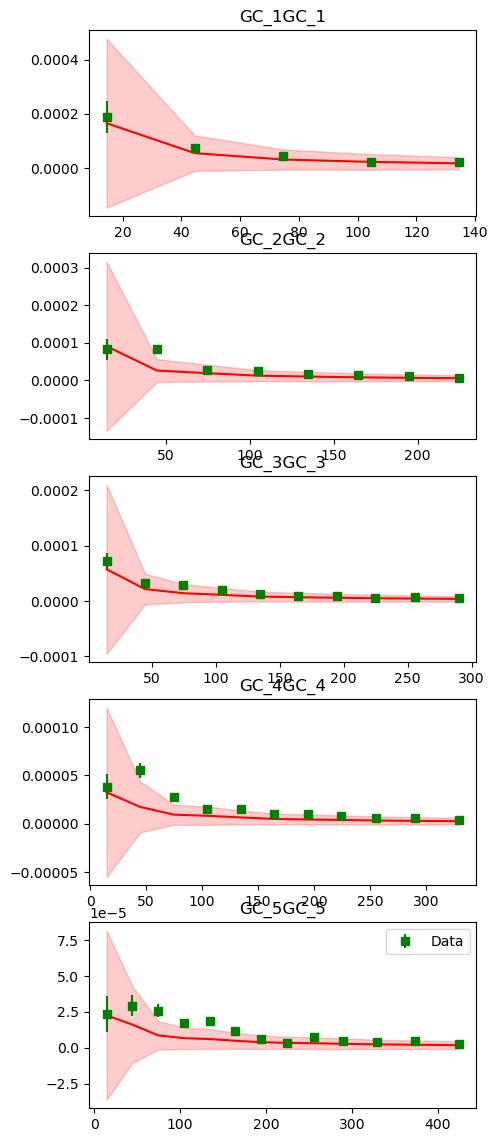

In [23]:
figure, axxis = plt.subplots(5, figsize=(5,14))
l = 1
for i in 1:5
    axxis[i].errorbar(files[string("ls_1", i-1, "1", i-1)],
                     data_vector[idx[l]:idx[l+1]-1], 
                     yerr=err[idx[l]:idx[l+1]-1], fmt="gs", label="Data")
    axxis[i].plot(vec(files[string("ls_1", i-1, "1", i-1)]),
                          vec(data_m[idx[l]:idx[l+1]-1]),
                          "r-")
    axxis[i].fill_between(vec(files[string("ls_1", i-1, "1", i-1)]),
                          vec(data_m[idx[l]:idx[l+1]-1] .+ data_s[idx[l]:idx[l+1]-1]),
                          vec(data_m[idx[l]:idx[l+1]-1] .- data_s[idx[l]:idx[l+1]-1]),
                          alpha=0.2, color="red")
    axxis[i].set_title(string("GC_", i, "GC_", i))
    l += 1
end

plt.legend()
plt.show()

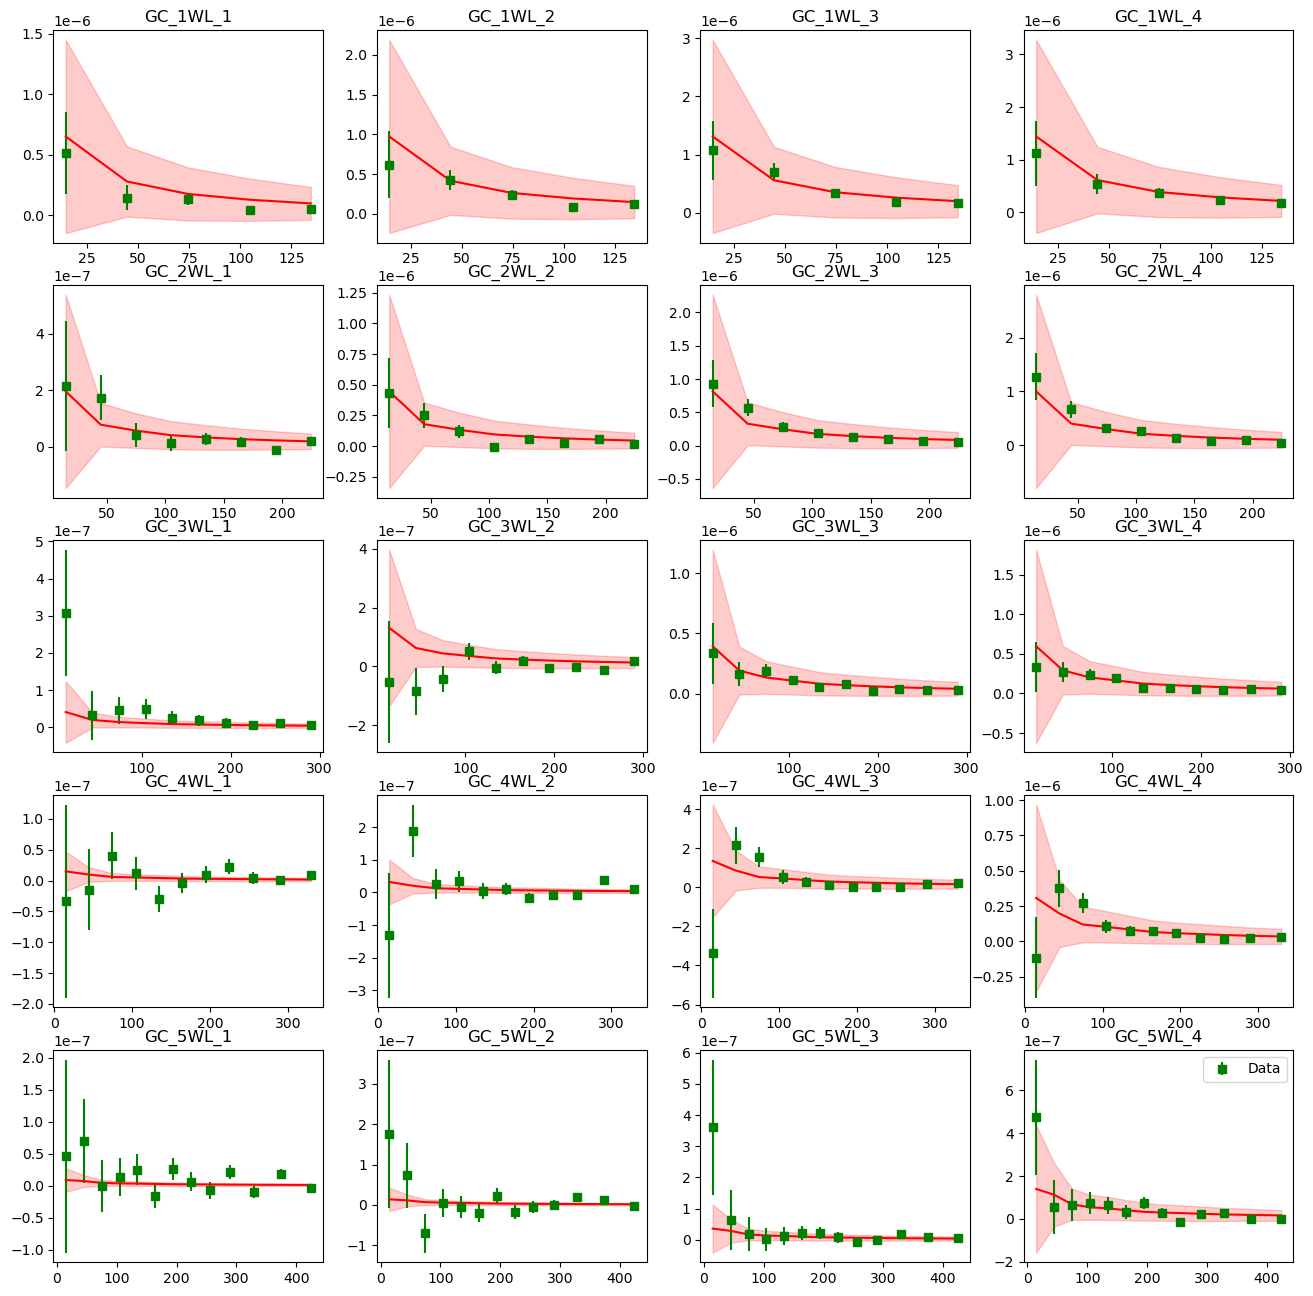

In [24]:
figure, axxis = plt.subplots(5, 4, figsize=(16,16))
l = 6
for i in 1:5
    for j in 1:4
        axxis[i, j].errorbar(files[string("ls_1", i-1,"2", j-1)], 
                            data_vector[idx[l]:idx[l+1]-1], 
                            yerr=err[idx[l]:idx[l+1]-1],
                            fmt="gs", label="Data")
        axxis[i, j].plot(vec(files[string("ls_1", i-1, "2", j-1)]),
                          vec(data_m[idx[l]:idx[l+1]-1]), "r-")
        axxis[i, j].fill_between(vec(files[string("ls_1", i-1, "2", j-1)]),
                          vec(data_m[idx[l]:idx[l+1]-1] .+ data_s[idx[l]:idx[l+1]-1]),
                          vec(data_m[idx[l]:idx[l+1]-1] .- data_s[idx[l]:idx[l+1]-1]),
                          alpha=0.2, color="red")
        axxis[i, j].set_title(string("GC_", i, "WL_", j))
        l += 1
    end
end
plt.legend()
plt.show()

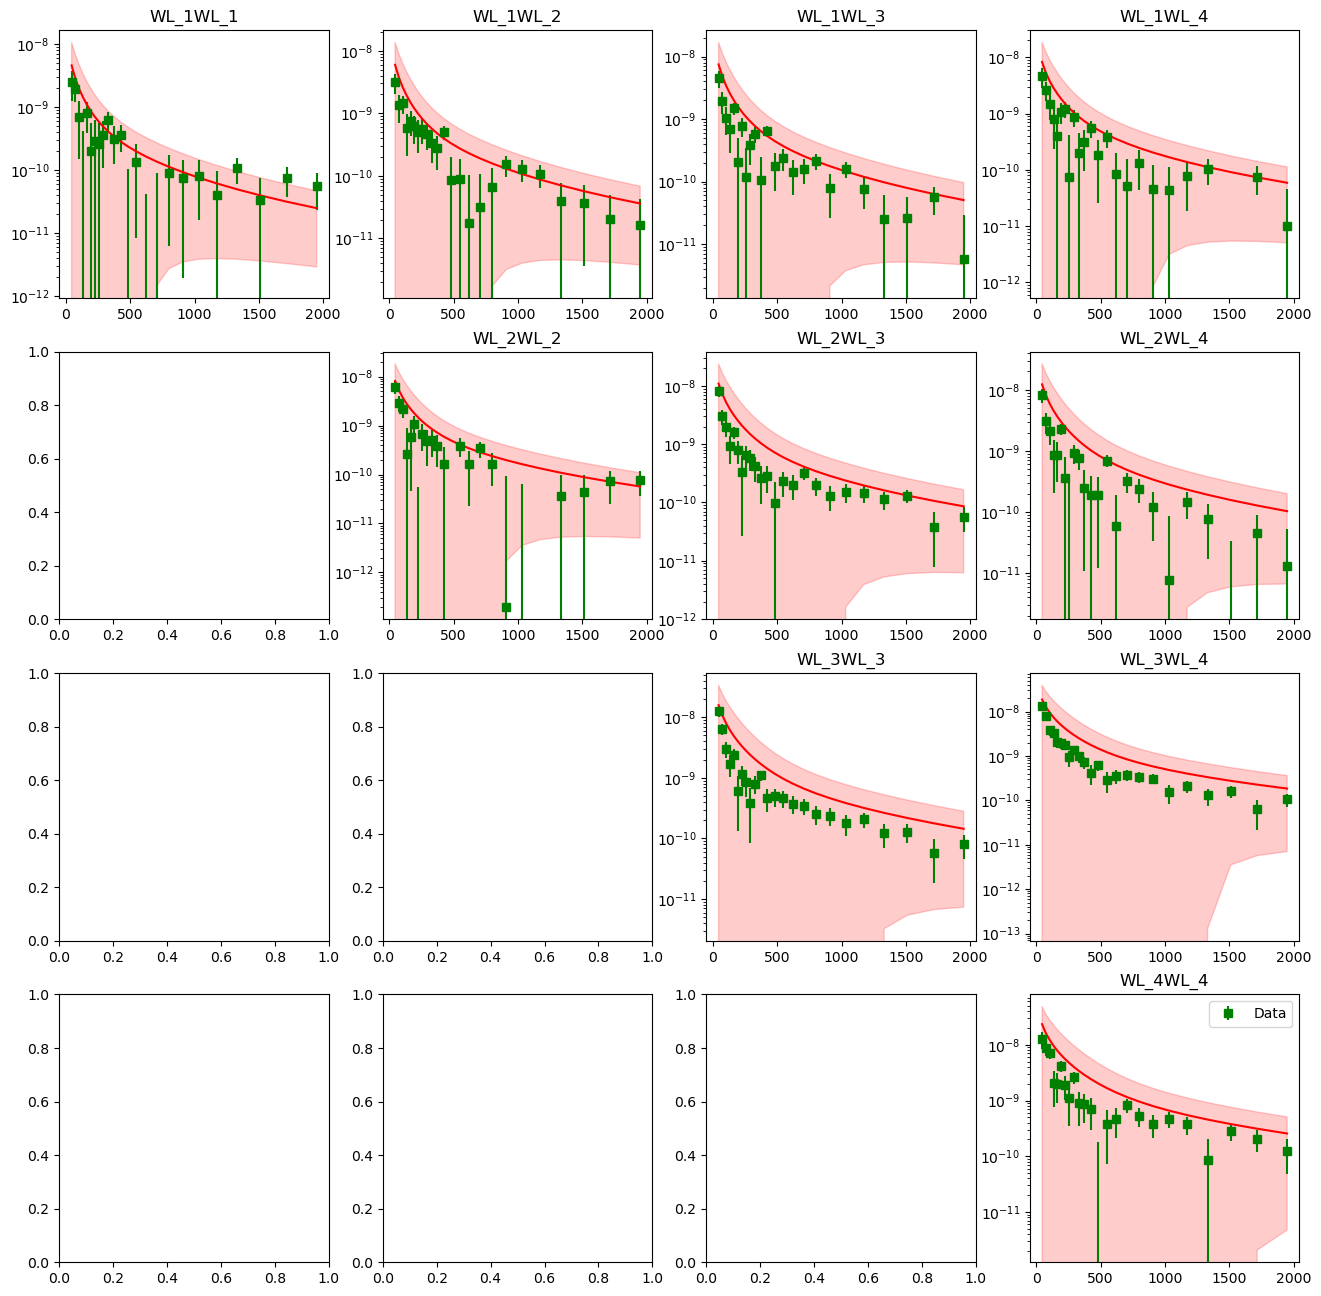

In [25]:
figure, axxis = plt.subplots(4, 4, figsize=(16,16))
l = 26
for i in 1:4
    for j in 1:4
        if j >= i
            axxis[i, j].errorbar(files[string("ls_2", i-1,"2", j-1)], 
                     data_vector[idx[l]:idx[l+1]-1], 
                     yerr=err[idx[l]:idx[l+1]-1], fmt="gs", label="Data")
            axxis[i, j].plot(vec(files[string("ls_2", i-1, "2", j-1)]),
                          vec(data_m[idx[l]:idx[l+1]-1]), "r-")
            axxis[i, j].fill_between(vec(files[string("ls_2", i-1, "2", j-1)]),
                          vec(data_m[idx[l]:idx[l+1]-1] .+ data_s[idx[l]:idx[l+1]-1]),
                          vec(data_m[idx[l]:idx[l+1]-1] .- data_s[idx[l]:idx[l+1]-1]),
                          alpha=0.2, color="red")
            axxis[i, j].set_title(string("WL_", i, "WL_", j))
            axxis[i, j].set_yscale("log")
            l += 1
        end 
    end 
end 
plt.legend()
plt.show()

In [34]:
@model function latent_GP(data; data_cov=cov_tot, cov_fn=sqexp_cov_fn, fid_cosmo=Cosmology())
    # Dimensions of predictors .
    # Dimensions of predictors .
    N = 100
    latent_x = Vector(0:0.3:3)
    x = zeros(100, 1)
    x[:, 1] = Vector(range(0., stop=3., length=N))
    latent_N = length(latent_x)
    total_N = N + latent_N
    total_x = [x; latent_x]
    # Distance matrix.
    D = pairwise(Distances.Euclidean(), total_x, dims=1)
    
    # Set up GP
    eta ~ Uniform(0.0, 0.5)
    l ~ Uniform(0.1, 3)
    v ~ MvNormal(zeros(11), ones(11))
    K = cov_fn(D, eta, l)
    Koo = K[(N+1):end, (N+1):end] # GP-GP cov
    Knn = K[1:N, 1:N]             # Data-Data cov
    Kno = K[1:N, (N+1):end]       # Data-GP cov
    
    latent_Dz = fid_cosmo.Dz(vec(latent_x))
    latent_gp = latent_Dz .+ cholesky(Koo).U' * v
    # Conditional 
    Koo_inv = inv(Koo)            
    C = Kno * Koo_inv
    gp = C * latent_gp
    
    Ωm ~ Uniform(0.1, 0.6)
    Ωb = 0.05 #~ Uniform(0.03, 0.07)
    h = 0.67 #~ Uniform(0.6, 0.9)
    ns = 0.96 #~ Uniform(0.87, 1.07)
    nuisances = Dict()
    cosmology = LimberJack.Cosmology(Ωm, Ωb, h, ns, 0.81;
                                     nz_pk=N,
                                     tk_mode="EisHu",
                                     Pk_mode="Halofit", 
                                     custom_Dz=gp)
    
    data = Theory(cosmology, Cls_meta, files;
                  Nuisances=nuisances).cls
    prediction ~ MvNormal(data, data_cov)
end

latent_GP (generic function with 1 method)

In [36]:
chain = sample(latent_GP(data_vector), HMC(0.001, 10), 10)

┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/jaime/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/jaime/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
Sampling:  20%|████████▎                                |  ETA: 0:08:01┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/jaime/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
Sampling: 100%|█████████████████████████████████████████| Time: 0:04:07


LoadError: InterruptException:

In [37]:
Ωm_p = group(chain, :Ωm).value.data[:, :, 1]
Ωb_p = group(chain, :Ωb).value.data[:, :, 1]
h_p = group(chain, :h).value.data[:, :, 1]
ns_p = group(chain, :ns).value.data[:, :, 1]
eta_p = group(chain, :eta).value.data[:, :, 1]
l_p = group(chain, :l).value.data[:, :, 1]
v_p = group(chain, :v).value.data[:, :, 1]

N_samples = length(eta_p)
latent_gps=zeros(N_samples, 11)
gps=zeros(N_samples, 100)
datas=zeros(N_samples, 475)


for i in 1:N_samples
    latent_gps[i, :], gps[i, :], datas[i, :] = model_latent_GP(eta_p, l_p, v_p, Ωm_p, Ωb_p, h_p, ns_p)
end

y_m, y_s = mean(ys, dims=1), std(ys, dims=1);
nonlin_y_m, nonlin_y_s = mean(nonlin_ys, dims=1), std(nonlin_ys, dims=1);
gp_m, gp_s = mean(gps, dims=1), std(gps, dims=1);

LoadError: UndefVarError: chain not defined

In [38]:
latent_gp_m, latent_gp_s = mean(latent_gps, dims=1), std(latent_gps, dims=1);
gp_m, gp_s = mean(gps, dims=1), std(gps, dims=1);
data_m, data_s = mean(datas, dims=1), std(datas, dims=1);

In [39]:
plt.plot(vec(data_x), data, "bo", label="Data")
plt.plot(gp_x, cosmology.Dz(gp_x), "k--", label="LCDM")
plt.plot(vec(gp_x), vec(gp_m), "r-")
plt.fill_between(vec(gp_x), vec(gp_m .+ gp_s),  vec(gp_m .- gp_s), alpha=0.2, color="red")
plt.title("Marginal Lkl GP - Non-linear model")

LoadError: UndefVarError: data_x not defined

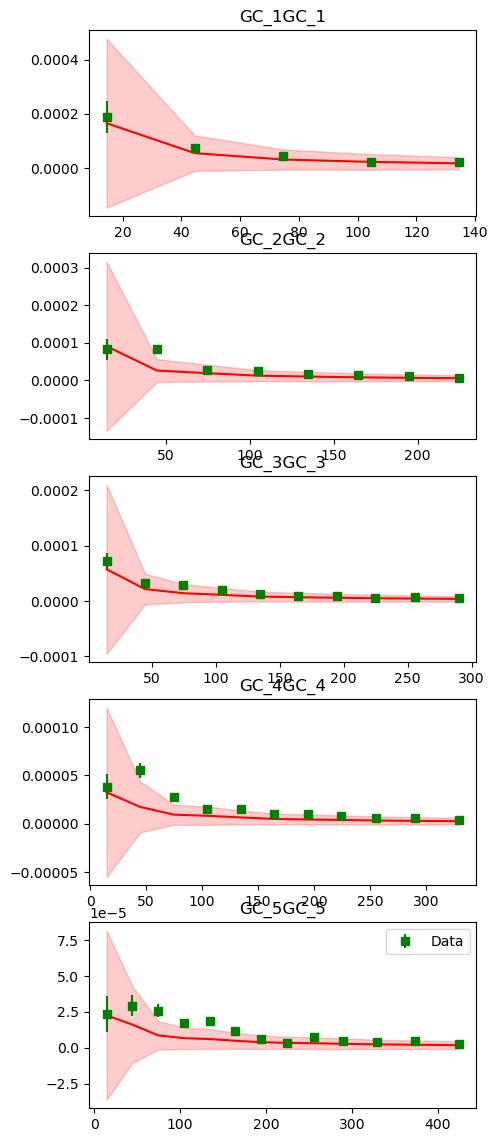

In [40]:
figure, axxis = plt.subplots(5, figsize=(5,14))
l = 1
for i in 1:5
    axxis[i].errorbar(files[string("ls_1", i-1, "1", i-1)],
                     data_vector[idx[l]:idx[l+1]-1], 
                     yerr=err[idx[l]:idx[l+1]-1], fmt="gs", label="Data")
    axxis[i].plot(vec(files[string("ls_1", i-1, "1", i-1)]),
                          vec(data_m[idx[l]:idx[l+1]-1]),
                          "r-")
    axxis[i].fill_between(vec(files[string("ls_1", i-1, "1", i-1)]),
                          vec(data_m[idx[l]:idx[l+1]-1] .+ data_s[idx[l]:idx[l+1]-1]),
                          vec(data_m[idx[l]:idx[l+1]-1] .- data_s[idx[l]:idx[l+1]-1]),
                          alpha=0.2, color="red")
    axxis[i].set_title(string("GC_", i, "GC_", i))
    l += 1
end

plt.legend()
plt.show()

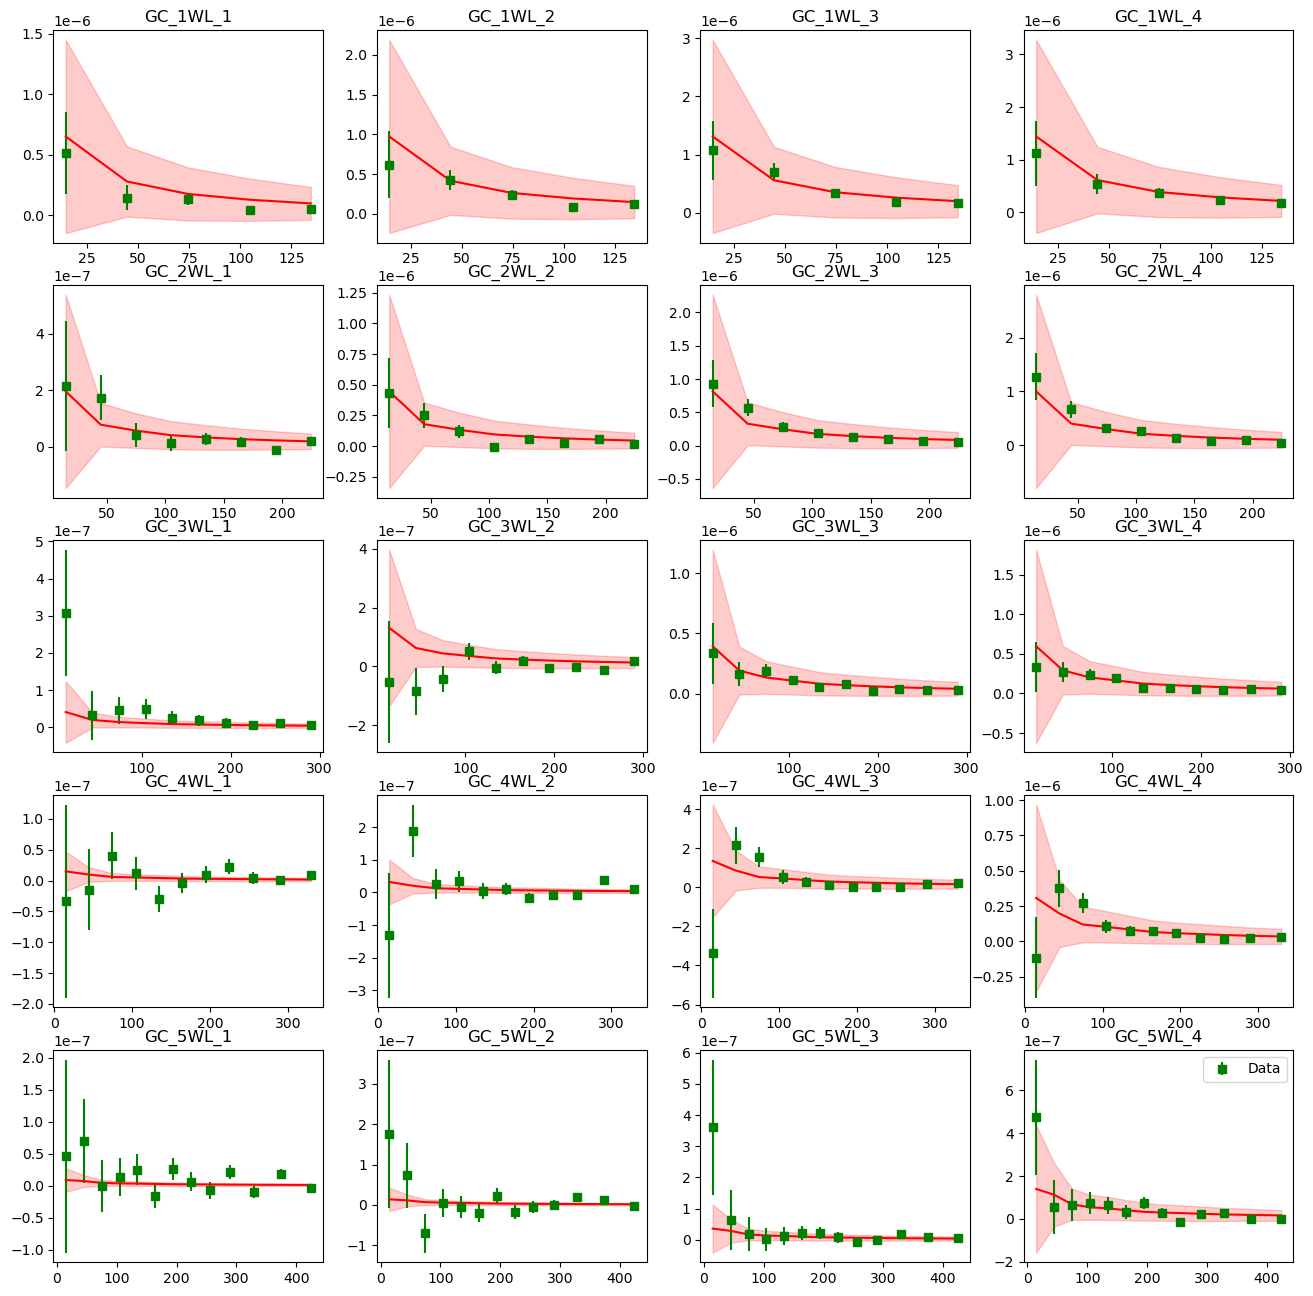

In [41]:
figure, axxis = plt.subplots(5, 4, figsize=(16,16))
l = 6
for i in 1:5
    for j in 1:4
        axxis[i, j].errorbar(files[string("ls_1", i-1,"2", j-1)], 
                            data_vector[idx[l]:idx[l+1]-1], 
                            yerr=err[idx[l]:idx[l+1]-1],
                            fmt="gs", label="Data")
        axxis[i, j].plot(vec(files[string("ls_1", i-1, "2", j-1)]),
                          vec(data_m[idx[l]:idx[l+1]-1]), "r-")
        axxis[i, j].fill_between(vec(files[string("ls_1", i-1, "2", j-1)]),
                          vec(data_m[idx[l]:idx[l+1]-1] .+ data_s[idx[l]:idx[l+1]-1]),
                          vec(data_m[idx[l]:idx[l+1]-1] .- data_s[idx[l]:idx[l+1]-1]),
                          alpha=0.2, color="red")
        axxis[i, j].set_title(string("GC_", i, "WL_", j))
        l += 1
    end
end
plt.legend()
plt.show()

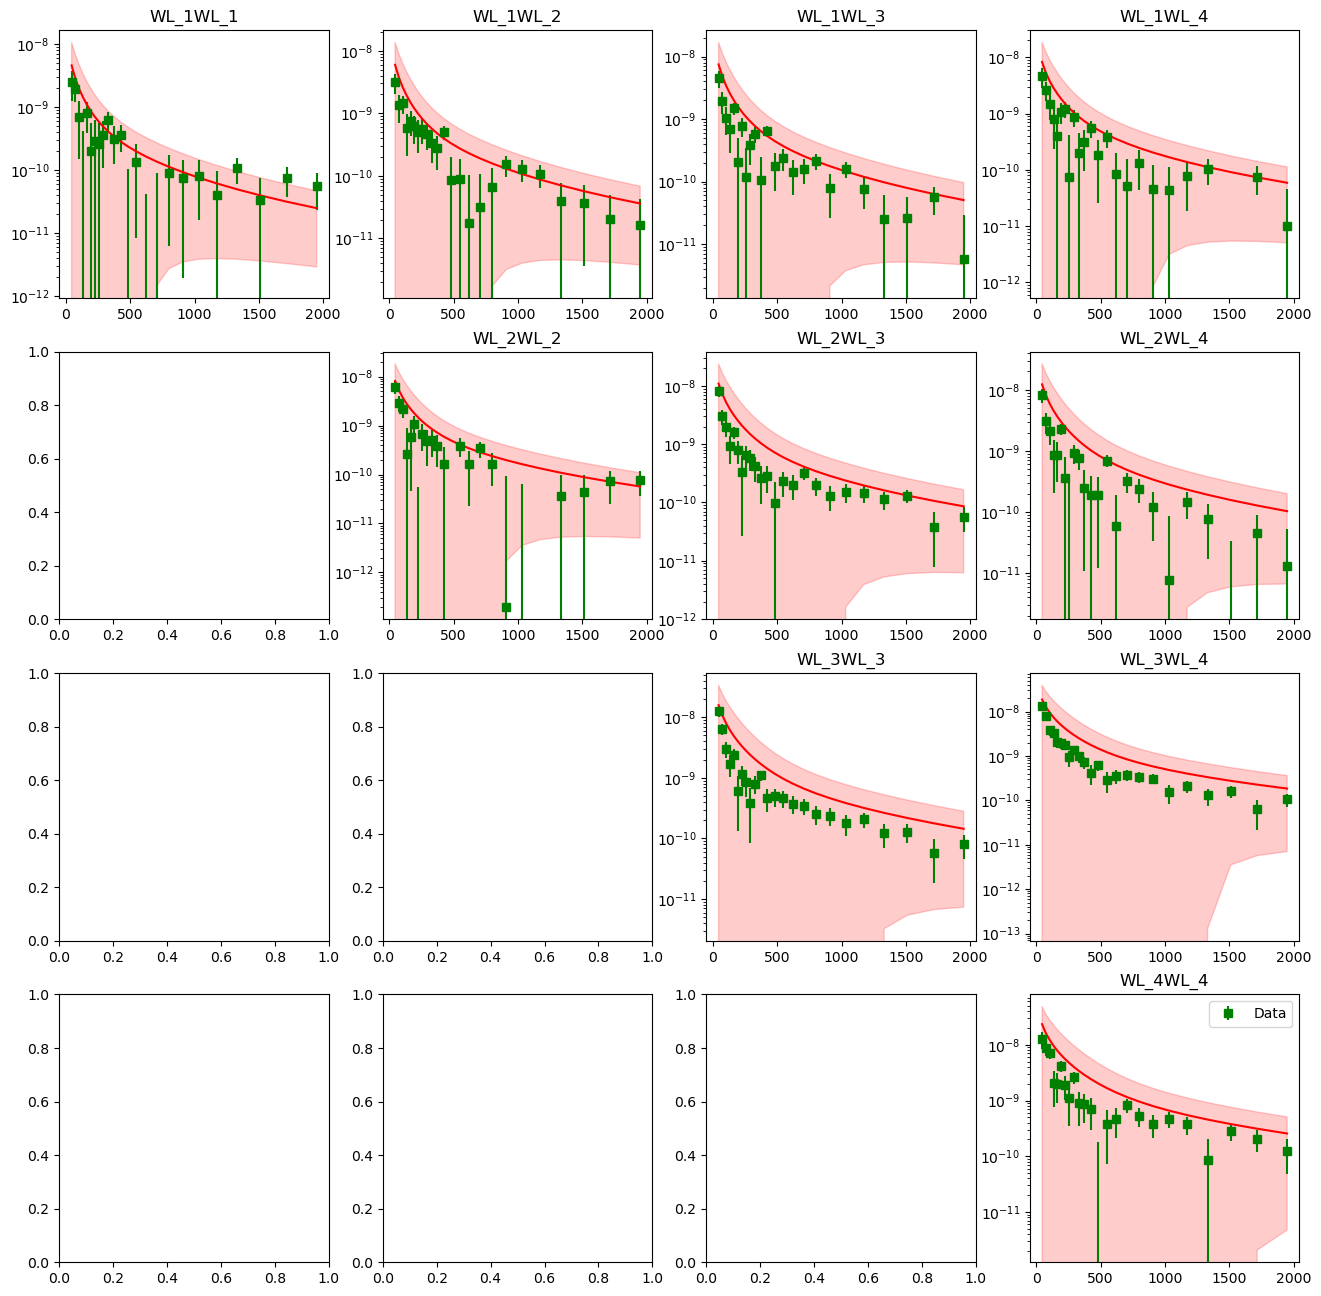

In [42]:
figure, axxis = plt.subplots(4, 4, figsize=(16,16))
l = 26
for i in 1:4
    for j in 1:4
        if j >= i
            axxis[i, j].errorbar(files[string("ls_2", i-1,"2", j-1)], 
                     data_vector[idx[l]:idx[l+1]-1], 
                     yerr=err[idx[l]:idx[l+1]-1], fmt="gs", label="Data")
            axxis[i, j].plot(vec(files[string("ls_2", i-1, "2", j-1)]),
                          vec(data_m[idx[l]:idx[l+1]-1]), "r-")
            axxis[i, j].fill_between(vec(files[string("ls_2", i-1, "2", j-1)]),
                          vec(data_m[idx[l]:idx[l+1]-1] .+ data_s[idx[l]:idx[l+1]-1]),
                          vec(data_m[idx[l]:idx[l+1]-1] .- data_s[idx[l]:idx[l+1]-1]),
                          alpha=0.2, color="red")
            axxis[i, j].set_title(string("WL_", i, "WL_", j))
            axxis[i, j].set_yscale("log")
            l += 1
        end 
    end 
end 
plt.legend()
plt.show()